In [1]:
import warnings

import pooch

# don't need to show warning about setting up optimizer
warnings.filterwarnings(
    "ignore",
    message="You will need to call setup",
    category=UserWarning,
)

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`ps_matlab_differences.ipynb`**!

:::

(ps-mat-diffs)=
# Notable differences between Matlab and Plenoptic Implementations

Plenoptic's implementation of the Portilla-Simoncelli texture model is based off of the [original matlab implementation](https://github.com/LabForComputationalVision/textureSynth). However, several changes have been made for the sake of: efficiency, compatibility with pytorch's gradient-based methods, and simplicity. They are described in this notebook.

In [2]:
from collections import OrderedDict

import einops
import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload 2

# We need to download some additional images for this notebook.
IMG_PATH = po.data.fetch_data("portilla_simoncelli_images.tar.gz")
CACHE_DIR = po.data.fetch_data("ps_regression.tar.gz")
# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

:::{admonition} This notebook retrieves cached synthesis results
:class: warning dropdown
As with the other Portilla-Simoncelli notebooks, we have cached the results of synthesis online and only download them for investigation in this notebook.

Additionally, while you can normally call {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` again to pick up where we left out, the cached version of the results discarded the optimizer's state dict (to reduce the size on disk). Thus, calling `met.synthesize(100)` with one of our cached and loaded metamer objects **will not** give the same result as calling `met.synthesize(200)` with a new metamer object initialized as shown in this notebook.

:::

1. **Optimization**. The matlab implementation of texture synthesis is designed specifically for the texture model.  Gradient descent is performed on subsets of the texture statistics in a particular sequence (coarse-to-fine, etc.). The plenoptic implementation relies on the auto-differentiation and optimization tools available in pytorch.  We only define the forward model and then allow pytorch to handle the optimization.

    Why does this matter? We have qualitatively reproduced the results but cannot guarantee exact reproducibility of synthesis from the matlab implementation. This means that, in general, metamers synthesized by the two versions will differ, though we believe that the metamers synthesized by plenoptic have a lower loss (see [](ps-optimization) for more discussion).

    In particular, in order for synthesis to find good results, we use a custom loss function that reweights the model's output. This is described in more detail in the [](ps-optimization) notebook, but in short: we upweight the variance of the highpass residuals and remove the pixel minimum and maximum from the gradient computation (this constraint is instead captured through the range penalty that is built into the {class}`~plenoptic.synthesize.metamer.Metamer` class).

3. **Lack of redundant statistics**. As described [below](ps-redundant-stats), we output a different number of statistics than the Matlab implementation. The number of statistics returned in `plenoptic` matches the number of statistics reported in the paper, unlike the Matlab implementation. That is because the Matlab implementation included many redundant statistics, which were either exactly redundant (e.g., symmetric values in an auto-correlation matrix), placeholders (e.g., some 0s to make the shapes of the output work out), or not mentioned in the paper. The implementation included in `plenoptic` returns only the necessary statistics.

(ps-true-correlations)=
4. **True correlations**. In the [Matlab implementation of Portilla Simoncelli statistics](https://github.com/LabForComputationalVision/textureSynth), the auto-correlation, cross-scale and cross-orientation statistics are based on co-variance matrices.  When using `torch` to perform optimization, this makes convergence more difficult. We thus normalize each of these matrices, dividing the auto-correlation matrices by their center values (the variance) and the cross-correlation matrices by the square root of the product of the appropriate variances (so that we match [numpy.corrcoef](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html)). This means that the center of the auto-correlations and the diagonals of `cross_orientation_correlation_magnitude` are always 1 and are thus excluded from the representation, as discussed above. We have thus added two new statistics, `std_reconstructed` and `magnitude_std` (the standard deviation of the reconstructed lowpass images and the standard deviation of the magnitudes of each steerable pyramid band), to compensate. Note that the cross-scale correlations have no redundancies and do not have 1 along the diagonal. For the `cross_orientation_correlation_magnitude`, the value at $A_{i,j}$ is the correlation between the magnitudes at orientation $i$ and orientation $j$ at the *same* scale, so that $A_{i,i}$ is the correlation of a magnitude band with itself, i.e., $1$. However, for `cross_scale_correlation_magnitude`, the value at $A_{i,j}$ is the correlation between the magnitudes at orientation $i$ and orientation $j$ at *two adjacent scales*, and thus $A_{i,i}$ is *not* the correlation of a band with itself; it is thus informative.

    :::{admonition} Why standard deviation and not variance?
    :class: dropdown hint

    We use standard deviations, instead of variances, because the value of the standard deviations lie within approximately the same range as the other values in the model's representation, which makes optimization work better.
    :::

(ps-redundant-stats)=
## Redundant statistics

The original Portilla-Simoncelli paper presents formulas to obtain the number of statistics in each class from the model parameters `n_scales` <!-- skip-lint -->, `n_orientations` and `spatial_corr_width` (labeled in the original paper $N$, $K$, and $M$ respectively). The formulas indicate the following statistics for each class:

* **Marginal statistics**: $2(N+1)$ skewness and kurtosis of lowpass images, $1$ high-pass variance, $6$ pixel statistics.
* **Raw coefficient correlation**: $(N+1)\frac{M^2+1}{2}$ statistics ($\frac{M^2+1}{2}$ auto-correlations for each scale including lowpass)
* **Coefficient magnitude statistics**: $NK\frac{M^2+1}{2}$ autocorrelation statistics, $N\frac{K(K-1)}{2}$ cross-orientation correlations at same scale, $K^2(N-1)$ cross-scale correlations.
* **Cross-scale phase statistics**: $2K^2(N-1)$ statistics

In particular, the paper reads _"For our texture examples, we have made choices of N = 4, K = 4 and M = 7, resulting in a total of 710 parameters"_. However, the output of the Portilla-Simoncelli code in [Matlab](https://github.com/LabForComputationalVision/textureSynth) contains 1784 elements for these values of $N$, $K$ and $M$. The discrepancy is because the Matlab output includes redundant statistics, placeholder values, and statistics not used during synthesis. The `plenoptic` output on the other hand returns only the essential statistics, and its output is in agreement with the papers formulas.

1) **Auto-correlation reconstructed**: An auto-covariance matrix $A$ encodes the covariance of the elements in a signal and their neighbors. Indexing the central auto-covariance element as $A_{0,0}$, element $A_{i,j}$ contains the covariance of the signal with it's neighbor at a displacement $i,j$. Because auto-correlation matrices are [even functions](https://en.wikipedia.org/wiki/Autocorrelation#Symmetry_property), they have a symmetry where $A_{i,j}=A_{-i,-j}$ which means that every element except the central one ($A_{0,0}$, the variance) is duplicated. Thus, in an autocorrelation matrix of size $M \times M$, there are $\frac{M^2+1}{2}$ non-redundant elements (see this ratio appear in the  auto-correlation statistics formulas above). The Matlab code returns the full auto-covariance matrices, that is, $M^2$ instead of $\frac{M^2+1}{2}$ elements for each covariance matrix.

    :::{admonition} Intuition for redundancies
    :class: dropdown hint

    This can be understood by thinking of $A_{i,0}$, the autocorrelation of every pixel and the pixel $i$ to their right. Computing this auto-covariance involves adding together all the products $I_{x,y}*I_{x+i,y}$ for every x and y in the image. But this is equivalent to computing $A_{-i,0}$, because every pair of two neighbors $i$ to the right $I_{x,y}*I_{x+i,y}$ is also a pair of neighbors $i$ to the left, $I_{x+i,y}*I_{(x+i)-i,y}=I_{x+i,y}*I_{x,y}$. So, any opposite displacements around the central element in the auto-covariance matrix will have the same value.
    :::

2) **Auto-correlation magnitude**: Same symmetry and redundancies as 1).
3) **Cross-orientation magnitude correlation**: Covariance matrices $C$ (size $K \times K$) have symmetry $C_{i,j} = C_{j,i}$ (each off-diagonal element is duplicated, i.e., [they're symmetric](https://en.wikipedia.org/wiki/Covariance_matrix#Basic_properties)). Thus, a $K \times K$ covariance matrix has $\frac{K(K+1)}{2}$ non-redundant elements. However, the diagonal elements of the cross-orientation correlations are variances, which are already contained in the central elements of the auto-correlation magnitude matrices. Thus, these covariances only hold $\frac{K(K-1)}{2}$ non-redundant elements (see this term in the formulas above). The Matlab code returns the full covariances (with $K^2$ elements) instead of the non-redundant ones. Also, the Matlab code returns an extra covariance matrix full of 0's not mentioned in the paper ($(N+1)$ matrices instead of $(N)$).
4) **Cross-scale real correlation (phase statistics)**: Phase statistics contain the correlations between the $K$ real orientations at a scale with the $2K$ real and imaginary phase-doubled orientations at the following scale, making a total of $K \times 2K=2K^2$ statistics (see this term in the formulas above). However, the Matlab output has matrices of size $2K \times 2K$, where half of the matrices are filled with 0's. Also, the paper counts the $(N-1)$ pairs of adjacent scales, but the Matlab output includes $N$ matrices. The `plenoptic` output removes the 0's and the extra matrix.
5) **Statistics not in paper**: The Matlab code outputs the mean magnitude of each band and cross-orientation real correlations, but these are not enumerated in the paper. These statistics are removed in `plenoptic`. See [below](ps-mag-means) for some more detail about the magnitude means.

As shown below, the output of `plenoptic` matches the number of statistics indicated in the paper:

In [3]:
img = po.tools.load_images(IMG_PATH / "fig4a.jpg")
img = img.to(DEVICE).to(torch.float64)

# Initialize the minimal model. Use same params as paper
model = po.simul.PortillaSimoncelli(
    img.shape[-2:], n_scales=4, n_orientations=4, spatial_corr_width=7
).to(DEVICE)

stats = model(img)

print(f"Stats for N=4, K=4, M=7: {stats[0].shape[1]} statistics")

Stats for N=4, K=4, M=7: 710 statistics


`plenoptic` allows users to convert the tensor of statistics into a dictionary containing matrices, similar to the Matlab output. In this dictionary, the redundant statistics are indicated with `NaN`s. We print one of the auto-correlation matrices showing the redundant elements it contains:

In [4]:
stats_dict = model.convert_to_dict(stats)
scale = 1
ori = 2
print(stats_dict["auto_correlation_magnitude"][0, 0, :, :, scale, ori])

tensor([[ 0.0077,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 0.0800,  0.1434,     nan,     nan,     nan,     nan,     nan],
        [ 0.0442,  0.3150,  0.6220,     nan,     nan,     nan,     nan],
        [-0.0039,  0.0177,  0.5022,     nan,     nan,     nan,     nan],
        [ 0.0150,  0.0171, -0.0338,  0.2946,     nan,     nan,     nan],
        [-0.0055,  0.0870,  0.2252,  0.0671,  0.0134,     nan,     nan],
        [-0.0460, -0.0640,  0.1255,  0.3936,  0.1982, -0.0199,     nan]],
       device='cuda:0', dtype=torch.float64)


We see in the output above that both the upper triangular part of the matrix, and the diagonal elements from the center onwards are redundant, as indicated in the text above. Note that although the central element is not redundant in auto-covariance matrices, when the covariances are converted to correlations, the central element is 1, and so uninformative (see [above](ps-true-correlations) for more information).

We can count how many statistics are in this particular class:

In [5]:
acm_not_redundant = torch.sum(~torch.isnan(stats_dict["auto_correlation_magnitude"]))
print(f"Non-redundant elements in acm: {acm_not_redundant}")

Non-redundant elements in acm: 384


The number of non redundant elements is 16 elements short of the $NK\frac{M^2+1}{2} = 4\cdot 4 \cdot \frac{7^2+1}{2}=400$ statistics indicated by the formula. This is because `plenoptic` removes the central elements of these matrices and holds them in `stats_dict['magnitude_std']`:

In [6]:
print(f"Number magnitude band variances: {stats_dict['magnitude_std'].numel()}")

Number magnitude band variances: 16


Next, lets see whether the number of statistics in each class match what is in the original paper:

1) **Marginal statistics**: Total of `17` statistics
    - kurtosis + skewness: `2*(N+1) = 2*(4+1) = 10`
    - variance of high pass band: `1`
    - pixel statistics: `6`
2) **Raw coefficient correlation**: Total of `125` statistics
    - Central samples of auto-correlation reconstructed: `(N+1)*(M^2+1)/2 = (4+1)*(7^2+1)/2 = 125`
3) **Coefficient magnitude statistics**: Total of `472` statistics
    - Central samples of auto-correlation of magnitude of each subband `N*K*(M^2+1)/2 = 4*4*(7^2+1)/2 = 400`
    - Cross-correlation of orientations in same scale: `N*K*(K-1)/2 = 4*4*(4-1)/2 = 24`
    - Cross-correlation of magnitudes across scale: `K^2*(N-1) = 4^2*(4-1) = 48`
4) **Cross-scale phase statistics**: Total `96` statistics
    - Cross-correlation of real coeffs with both coeffs at broader scale: `2*K^2*(N-1) = 2*4^2*(4-1) = 96`

In [7]:
# Sum marginal statistics
marginal_stats_num = (
    torch.sum(~torch.isnan(stats_dict["kurtosis_reconstructed"]))
    + torch.sum(~torch.isnan(stats_dict["skew_reconstructed"]))
    + torch.sum(~torch.isnan(stats_dict["var_highpass_residual"]))
    + torch.sum(~torch.isnan(stats_dict["pixel_statistics"]))
)
print(f"Marginal statistics: {marginal_stats_num} parameters, compared to 17 in paper")

# Sum raw coefficient correlations
real_coefficient_corr_num = torch.sum(
    ~torch.isnan(stats_dict["auto_correlation_reconstructed"])
)
real_variances = torch.sum(~torch.isnan(stats_dict["std_reconstructed"]))


print(
    f"Raw coefficient correlation: {real_coefficient_corr_num + real_variances} "
    f"parameters, compared to 125 in the paper"
)


# Sum coefficient magnitude statistics
coeff_magnitude_stats_num = (
    torch.sum(~torch.isnan(stats_dict["auto_correlation_magnitude"]))
    + torch.sum(~torch.isnan(stats_dict["cross_scale_correlation_magnitude"]))
    + torch.sum(~torch.isnan(stats_dict["cross_orientation_correlation_magnitude"]))
)
coeff_magnitude_variances = torch.sum(~torch.isnan(stats_dict["magnitude_std"]))

print(
    "Coefficient magnitude statistics: "
    f"{coeff_magnitude_stats_num + coeff_magnitude_variances} "
    "parameters, compared to 472 in paper"
)

# Sum cross-scale phase statistics
phase_statistics_num = torch.sum(
    ~torch.isnan(stats_dict["cross_scale_correlation_real"])
)
print(f"Phase statistics: {phase_statistics_num} parameters, compared to 96 in paper")

Marginal statistics: 17 parameters, compared to 17 in paper
Raw coefficient correlation: 125 parameters, compared to 125 in the paper
Coefficient magnitude statistics: 472 parameters, compared to 472 in paper
Phase statistics: 96 parameters, compared to 96 in paper


(ps-mag-means)=
## Magnitude means

The mean of each magnitude band are slightly different from the redundant statistics discussed in the previous section. Each of those statistics are exactly redundant, e.g., the center value of an autocorrelation matrix will always be 1. They thus cannot include any additional information. However, the magnitude means are not redundant in this manner and thus could improve the texture representation. The authors excluded these values because they did not seem to be necessary: the magnitude means are constrained by the other statistics (in particular, the standard deviations of the [magnitudes](ps-mag-corrs) and of the [reconstructed lowpass images](ps-coeff-corrs)), and thus including them does not improve the visual quality of the synthesized textures. We can thus think of them as "approximately" or "statistically" redundant.

To demonstrate this, we will create a modified version of the `PortillaSimoncelli` <!-- skip-lint --> class which includes the magnitude means to demonstrate:

1. Even without explicitly including them in the texture representation, they are still approximately matched between the original and synthesized texture images.
2. Including them in the representation does not significantly improve the perceptual quality of the synthesized texture.

First, let's create the modified model:

In [8]:
class PortillaSimoncelliMagMeans(po.simul.PortillaSimoncelli):
    r"""Include the magnitude means in the PS texture representation.

    Parameters
    ----------
    im_shape: int
        the size of the images being processed by the model

    """

    def __init__(
        self,
        im_shape,
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=7)

    def forward(self, image, scales=None):
        r"""Average Texture Statistics representations of two image

        Parameters
        ----------
        image : torch.Tensor
            A 4d tensor (batch, channel, height, width) containing the image(s) to
            analyze.
        scales : list, optional
            Which scales to include in the returned representation. If an empty
            list (the default), we include all scales. Otherwise, can contain
            subset of values present in this model's scales attribute.

        Returns
        -------
        representation_tensor: torch.Tensor
            3d tensor of shape (batch, channel, stats) containing the measured
            texture statistics.

        """
        stats = super().forward(image, scales=scales)
        # this helper function returns a list of tensors containing the steerable
        # pyramid coefficients at each scale
        pyr_coeffs = self._compute_pyr_coeffs(image)[1]
        # only compute the magnitudes for the desired scales
        magnitude_pyr_coeffs = [
            coeff.abs()
            for i, coeff in enumerate(pyr_coeffs)
            if scales is None or i in scales
        ]
        magnitude_means = [mag.mean((-2, -1)) for mag in magnitude_pyr_coeffs]
        return einops.pack([stats, *magnitude_means], "b c *")[0]

    # overwriting these following two methods allows us to use the plot_representation
    # method with the modified model, making examining it easier.
    def convert_to_dict(self, representation_tensor: torch.Tensor) -> OrderedDict:
        """Convert tensor of stats to dictionary."""
        n_mag_means = self.n_scales * self.n_orientations
        rep = super().convert_to_dict(representation_tensor[..., :-n_mag_means])
        mag_means = representation_tensor[..., -n_mag_means:]
        rep["magnitude_means"] = einops.rearrange(
            mag_means,
            "b c (s o) -> b c s o",
            s=self.n_scales,
            o=self.n_orientations,
        )
        return rep

    # overwriting this method is necessary for the loss factory to work
    def convert_to_tensor(self, representation_dict: OrderedDict) -> torch.Tensor:
        """Convert dictionary of statistics to a tensor."""
        rep = super().convert_to_tensor(representation_dict)
        return torch.cat(
            [rep, representation_dict["magnitude_means"].flatten(-2, -1)], -1
        )

    def _representation_for_plotting(self, rep: OrderedDict) -> OrderedDict:
        r"""Convert the data into a dictionary representation that is more convenient
        for plotting.

        Intended as a helper function for plot_representation.
        """
        mag_means = rep.pop("magnitude_means")
        data = super()._representation_for_plotting(rep)
        data["magnitude_means"] = mag_means.flatten()
        return data

Now, let's initialize our models and images for synthesis:

In [9]:
img = po.tools.load_images(IMG_PATH / "fig4a.jpg").to(DEVICE).to(torch.float64)
model = po.simul.PortillaSimoncelli(img.shape[-2:], spatial_corr_width=7).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
model_mag_means = PortillaSimoncelliMagMeans(img.shape[-2:]).to(DEVICE)
loss_mag_means = po.tools.optim.portilla_simoncelli_loss_factory(model_mag_means, img)

And run the synthesis with the regular model, which does not include the mean of the steerable pyramid magnitudes, and then the augmented model, which does.

In [10]:
# Set the RNG seed to make the two synthesis procedures as similar as possible.
po.tools.set_seed(100)
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / "ps_mag_means-False.pt", map_location=DEVICE)

po.tools.set_seed(100)
met_mag_means = po.synth.Metamer(
    img,
    model_mag_means,
    loss_function=loss_mag_means,
)
met_mag_means.load(CACHE_DIR / "ps_mag_means-True.pt", map_location=DEVICE)

:::{admonition} How to run this synthesis manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_mag_means -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)
```

Call the {func}`~plenoptic.synthesize.metamer.Metamer.setup` and {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` methods of `met_mag_means` with the same arguments.

:::

Now let's examine the outputs. In the following plot, we display the synthesized metamer and the representation error for the metamer synthesized with and without explicitly constraining the magnitude means.

- The two synthesized metamers appear almost identical, so including the magnitude means does not substantially change the resulting metamer at all, let alone improve its visual quality.
- The representation errors are (as we'd expect) also very similar. Let's focus on the plot in the bottom right, labeled "magnitude_means". Each stem shows the mean of one of the magnitude bands, with the scales increasing from left to right. Looking at the representation error for the first image, we can see that, even without explicitly including the means, the error in this statistic is on the same magnitude as the other statistics, showing that it is being implicitly constrained. By comparing to the error for the second image, we can see that the error in the magnitude means does decrease, most notably in the coarsest scales.

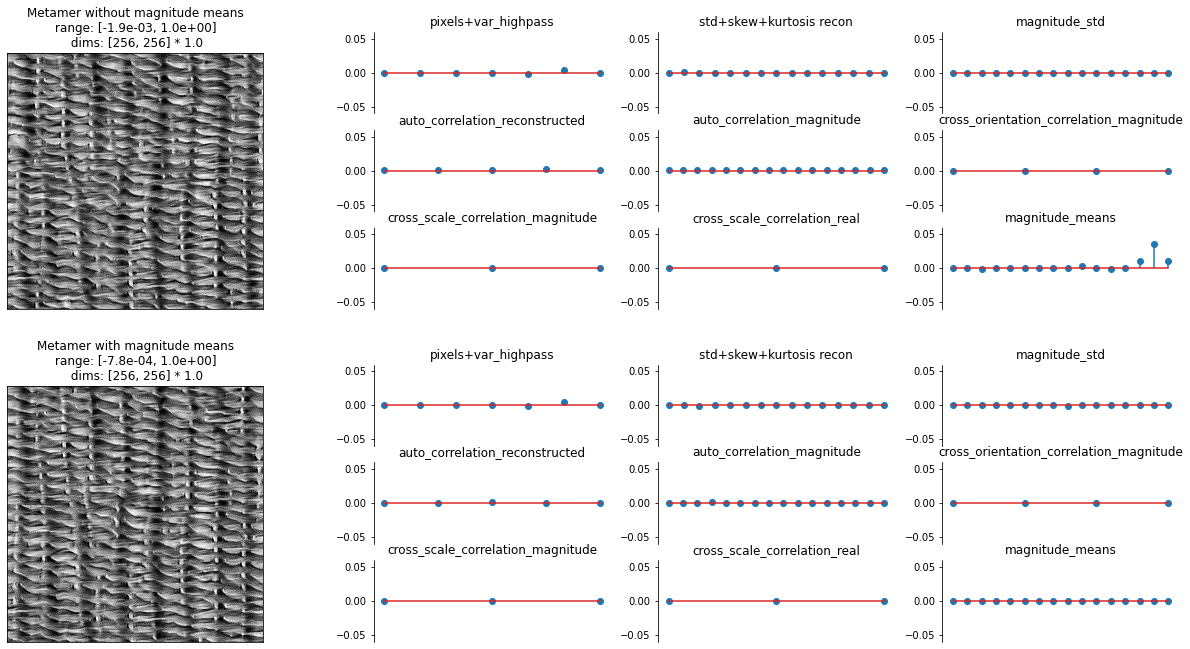

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(21, 11), gridspec_kw={"width_ratios": [1, 3.1]})
for ax, im, info in zip(
    axes[:, 0], [met.metamer, met_mag_means.metamer], ["without", "with"]
):
    po.imshow(im, ax=ax, title=f"Metamer {info} magnitude means")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

model_mag_means.plot_representation(
    model_mag_means(met.metamer) - model_mag_means(img),
    ylim=(-0.06, 0.06),
    ax=axes[0, 1],
)
model_mag_means.plot_representation(
    model_mag_means(met_mag_means.metamer) - model_mag_means(img),
    ylim=(-0.06, 0.06),
    ax=axes[1, 1],
);

Thus, we can feel fairly confident in excluding these magnitude means from the model. Note this follows the same logic as the [](ps-model-stats) notebook, when we tried removing different statistics to see their effect; here, we tried *adding* a statistic to determine its effect. Feel free to try using other target images or adding other statistics!